# Maximum Likelihood Amplitude Estimator 

We have Maximum Likelihood Amplitude Estimator(MLAE) with pennylane package. 
In this project, we have compared 3 algorithms to compute amplitude. In here, we focused on MLAE.

Assume that A is an oracle, that encodes f(x) on n qubits. For details, please refer to #TODO


In [29]:
import numpy as np 
from scipy import optimize 
import pennylane as qml 

import matplotlib.pyplot as plt

## Amplitude estimation with arbitrary p(x), f(x) 

With arbitrary probability distribution p(x) and any function f(x), we can compute its integration with quantum computer.    
The below code shows the integration was successful within small error for any p(x), f(x).

In [114]:
n_qubits = 6
n = n_qubits - 1
N=2**(n_qubits - 1)
target = n_qubits-1

# Example p and theta_i
p = np.ones(32)/32
theta_i = np.sin(np.arange(32)/6)
assert len(p) == 2**n
assert len(theta_i)==2**n
a = np.sum(p * np.sin(theta_i/2)**2)

def Rotf(n, theta_i):
    for i in range(2**n):
        binary=format(i, 'b').zfill(n)
        qml.ctrl(qml.RY, range(n) , control_values=[int(x) for x in binary])(theta_i[i], wires=n)

# Set A 
def A(p,theta_i,n):
    # prepare state 
    psi = np.sqrt(p)
    overlap = psi[0]
    denominator = np.sqrt(2 + 2 * overlap)
    psi[0] += 1
    psi /= denominator

    dim = len(p)
    qml.QubitUnitary(2 * np.outer(psi, psi) - np.eye(dim), wires=range(n))
    # encode f[x] = sin^2(theta_i[x]/2)
    Rotf(n,theta_i)
    
def reflect(n_qubits, target):
    for i in range( n_qubits):
        qml.PauliX(wires =i)
    qml.ctrl(qml.PauliZ, range(n_qubits-1), control_values=[1 for _ in range(n_qubits-1)])(wires = target)
    for i in range( n_qubits):
        qml.PauliX(wires =i)
        
def Q(p, theta_i, n, target):
    # reflect respect to |psi_g>|1> 
    qml.PauliZ(wires = target)
    # reflect respect to chi
    qml.adjoint(A)(p,theta_i,n)
    reflect(n+1, target)
    A(p,theta_i,n)
    
def cal_theta(n_grovers, hits, shots):
    # set range 
    m =  10**(-15)
    M = 1 - m
    thetas = [] 
    for i, n_grover in enumerate(n_grovers):

        def log_likelihood(probs):
            theta = np.arcsin(np.sqrt(probs))
            p = np.zeros_like(probs)
            for j in range(i+1):
                phi = (2 * n_grovers[j]+1) * theta
                p +=  2 * hits[j] * np.log(np.abs(np.sin(phi))) \
                    +2*(shots - hits[j])*np.log(np.abs(np.cos(phi)))
            
            return -p
        result = optimize.brute(log_likelihood, [(m, M)])
        p_cand = result[0]
        thetas.append(np.arcsin(np.sqrt(p_cand)))
        p_error = CM_error_bound(n_grovers, i, p_cand, shots)
        M = min(p_cand + 5 * p_error, 1-10**(-15))
        m = max(p_cand - 5 * p_error, 10**(-15))
    return thetas 

def CM_error_bound(n_grovers, M, p, shots):
    #Fisher_info = 0
    Fisher_info = np.sum((2*np.array(n_grovers[:M+1])+1)**2)
    Fisher_info = Fisher_info*shots / (p * (1 - p)) 
    return np.sqrt(1 / Fisher_info)

In [115]:
shots = 1000
n_qubits = 5
n = 4 
target = 4

dev = qml.device('default.qubit', wires = n_qubits, shots = shots)
n_grovers =[0,1,2,4,8,16,32]
p = np.ones(16)/16
theta_i = np.sin(np.arange(16)/6)
ret = []
for n_grover in n_grovers:
    @qml.qnode(device = dev)
    def circuit():
        A(p, theta_i, n) 
        print(n_grover)
        for _ in range(n_grover):
            Q(p,theta_i, n,target)
        return qml.sample(wires = target)
    ret.append(circuit())

0
1
2
4
8
16
32


In [117]:
hits = []
for i in ret: 
    hits.append(np.sum(i).item()) # count number of 1s 
print(hits)

[146, 800, 915, 47, 6, 55, 543]


Text(0.5, 0, 'depth(# of Oracle)')

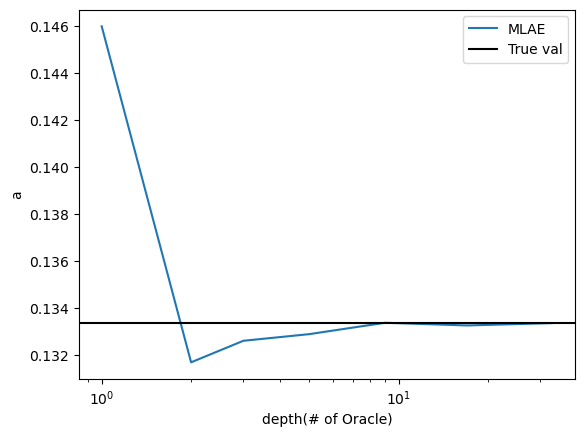

In [118]:
theta_Candidates = cal_theta(n_grovers, hits, shots=shots)
plt.plot(np.array(n_grovers)+1, np.sin(theta_Candidates)**2, label = 'MLAE')
a = np.sum(p * np.sin(theta_i/2)**2)
plt.axhline(a, c='k', label = 'True val')
plt.legend()
plt.xscale('log')
plt.ylabel('a')
plt.xlabel('depth(# of Oracle)')

## Test cuQuantum with 'lightning.gpu' device 
Unfortunately, lightning.gpu device worked poorly with multi-controlled gates.      
I wanted to figure why the result with lightning.gpu differs from the result with default.qubit device but failed due to time limit.    
Hence, we have used uniform distribution as p(x) and $sin^2(x)$ as f(x) since this f(x) can be expressed with controlled-RY gates. 

In [27]:
shots = 1000 
dev = qml.device('lightning.gpu', wires = 5, shots = shots)
@qml.qnode(device=dev) 
def circuit(): 
    n_qubits = 5
    b_max = np.pi/5
    N = 2**(n_qubits-1)
    target = n_qubits -1

    # define function 
    def A():
        # superposition 
        for i in range(n_qubits-1):
            qml.Hadamard(wires = i)
        # encode f(x)
        qml.RY(b_max/N, wires = target )
        for i in range(n_qubits-1):
            qml.CRY(2**(i+1) * b_max / N , wires = [i, target])
            
    def reflect():
        for i in range( n_qubits):
            qml.PauliX(wires =i)
        qml.ctrl(qml.PauliZ, range(n_qubits-1), control_values=[1 for _ in range(n_qubits-1)])(wires = target)
        for i in range( n_qubits):
            qml.PauliX(wires =i)
    def A_inv():
        # inverse of A 
        for i in range(n_qubits-2, -1, -1):
            qml.CRY(-2**(i+1) * b_max / N, wires = [i, target])
        qml.RY(-b_max/N, wires = target )  

        for i in range(n_qubits-1):
            qml.Hadamard(wires = i)
    def Q():
        # reflect respect to |psi_g>|1> 
        qml.PauliZ(wires = target)
        # reflect respect to chi
        A_inv()
        reflect()
        A()
    
    # start circuit 
    
    A()
    Q()
    return qml.sample(wires = target) 

ret = circuit()

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

## Compare MLAE with Monte-Carlo method(MC)
We have compared the MLAE and MC result varying shots.    


Analytical Result: 0.03225535810568046


/tmp/ipykernel_2065/3964585.py:55: RuntimeWarning: invalid value encountered in sqrt
  theta = np.arcsin(np.sqrt(probs))


shot: 200 |표준편차 추정값(MLQAE) 0.0025926020057125345 , Relative error 0.15316386656720268
shot: 1000 |표준편차 추정값(MLQAE) 0.0010124029702217598 , Relative error 0.06831111378675488
shot: 5000 |표준편차 추정값(MLQAE) 0.00046160628253775614 , Relative error 0.029139153427989672
shot: 25000 |표준편차 추정값(MLQAE) 0.00021339397687087535 , Relative error 0.013314236519621794
shot: 125000 |표준편차 추정값(MLQAE) 9.428342170419586e-05 , Relative error 0.006108093958785797


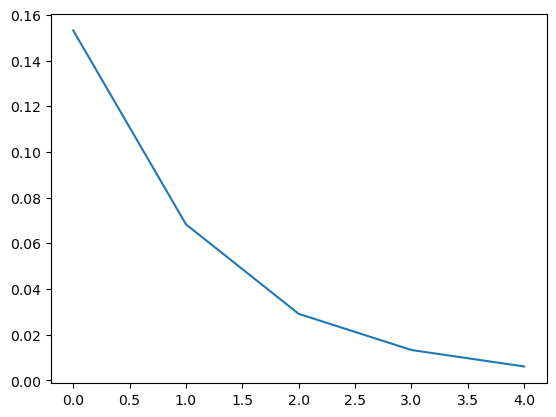

In [106]:
shots_list =  [200,1000,5000,25000,125000] # 
# dev = qml.device('default.qubit', wires = n_qubits, shots = shots)
n_qubits = 8
y = np.pi/10
N = 2**(n_qubits-1)
target = n_qubits -1

# dev = qml.device('lightning.gpu', wires = n_qubits, shots = shots)
n_grovers = np.arange(6) #[0,1,2,4,8,16,32]

analytic_result = (y / 2. - np.sin(2 * y) / 4.)/y 
print("Analytical Result:", analytic_result)

repeat =100
errors = []
for shots in shots_list:
    dev = qml.device('lightning.gpu', wires = n_qubits, shots = shots)
    # dev = qml.device('default.qubit', wires = n_qubits, shots = shots)
    
    ret_rep = [] 
    for _ in range(repeat): 
        
        ret = []
        for n_grover in n_grovers:
            @qml.qnode(device = dev)
            def circuit(n_grover):


                # define function 

                def A():
                    # superposition 
                    for i in range(n_qubits-1):
                        qml.Hadamard(wires = i)
                    # encode f(x)
                    qml.RY(y/N, wires = target )
                    for i in range(n_qubits-1):
                        qml.CRY(2**(i+1) * y/ N , wires = [i, target])

                def reflect():
                    for i in range( n_qubits):
                        qml.PauliX(wires =i)
                    qml.ctrl(qml.PauliZ, range(n_qubits-1), control_values=[1 for _ in range(n_qubits-1)])(wires = target)
                    for i in range( n_qubits):
                        qml.PauliX(wires =i)
                def A_inv():
                    # inverse of A 
                    for i in range(n_qubits-2, -1, -1):
                        qml.CRY(-2**(i+1) * y / N, wires = [i, target])
                    qml.RY(-y/N, wires = target )  

                    for i in range(n_qubits-1):
                        qml.Hadamard(wires = i)
                def Q():
                    # reflect respect to |psi_g>|1> 
                    qml.PauliZ(wires = target)
                    # reflect respect to chi
                    A_inv()
                    reflect()
                    A()

                # start circuit 
                A()
                for _ in range(n_grover): 
                    Q()
                return qml.sample(wires = target)
            ret.append(circuit(n_grover))
        hits = []
        for i in ret: 
            hits.append(np.sum(i).item()) # count number of 1s 
        # print(hits)
        theta_Candidates = cal_theta(n_grovers, hits, shots=shots)
        ret_rep.append(np.sin(theta_Candidates)**2)
    print(f'shot: {shots} |'+'std estimation(MLQAE)', np.mean(np.abs(np.array(ret_rep)-analytic_result)), ', Relative error', np.std(ret_rep)/analytic_result) #*np.sqrt(100), 
    errors.append(np.std(ret_rep)/analytic_result)
plt.plot(errors)
        

Analytical Result: 0.03225535810568046
shot: 1200 |표준편차 추정값 0.0051699653448226005 표준편차 참값 0.005100241005674371 , Relative error 0.16028237317607466
shot: 6000 |표준편차 추정값 0.0024395605250855236 표준편차 참값 0.0022808971180639567 , Relative error 0.07563272176649295
shot: 30000 |표준편차 추정값 0.0009979990536624324 표준편차 참값 0.0010200482011348741 , Relative error 0.030940566537584827
shot: 150000 |표준편차 추정값 0.0005275380976237117 표준편차 참값 0.0004561794236127913 , Relative error 0.016355053194427482
shot: 750000 |표준편차 추정값 0.0001908891284955164 표준편차 참값 0.00020400964022697482 , Relative error 0.00591805950100114


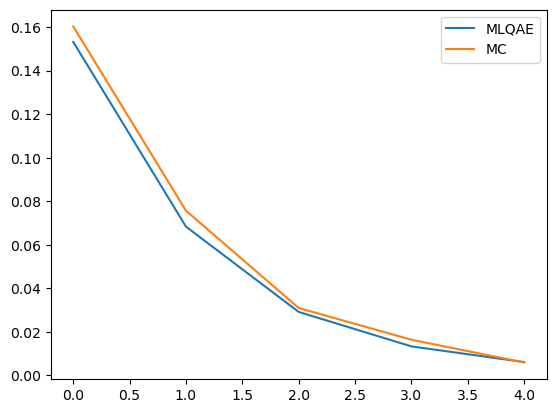

In [107]:
# shots_list =  [ 200,1000,5000,25000,125000,625000]
shots_list = np.array(shots_list)*6
#*8
repeat = 100
n_qubits = 8
y = np.pi/10
N = 2**(n_qubits-1)
target = n_qubits -1

# dev = qml.device('lightning.gpu', wires = n_qubits, shots = shots)

analytic_result = (y / 2. - np.sin(2 * y) / 4.)/y 
print("Analytical Result:", analytic_result)

errors_direct=[]
for shots in shots_list:
    dev = qml.device('default.qubit', wires = n_qubits, shots = int(shots))
    ret_rep = [] 
    for _ in range(repeat): 
        @qml.qnode(device = dev)
        def circuit():
            # define function 

            def A():
                # superposition 
                for i in range(n_qubits-1):
                    qml.Hadamard(wires = i)
                # encode f(x)
                qml.RY(y/N, wires = target )
                for i in range(n_qubits-1):
                    qml.CRY(2**(i+1) * y/ N , wires = [i, target])

            # start circuit 
            A()
            return qml.sample(wires = target)
        ret_rep.append(np.mean(circuit()))
    print(f'shot: {shots} |'+'std estimation', np.std(ret_rep),'std true', np.sqrt(1/(shots)*analytic_result * ( 1- analytic_result)), ', Relative error', np.std(ret_rep)/analytic_result) #*np.sqrt(100), 
    
    errors_direct.append(np.std(ret_rep)/analytic_result)
plt.plot(errors, label = 'MLQAE')
plt.plot(errors_direct, label = 'MC')
plt.legend()

Text(0, 0.5, 'Relative Error')

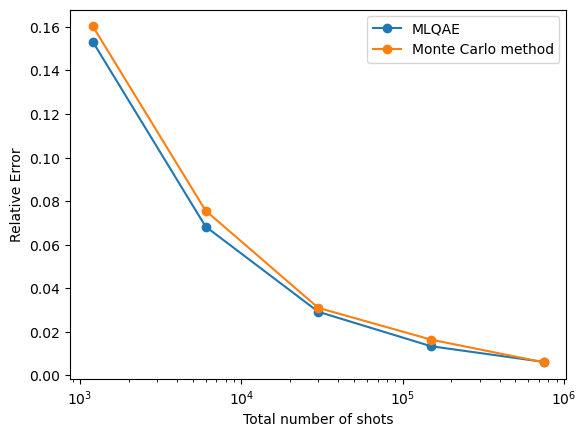

In [120]:

plt.plot(shots_list,errors,'-o', label = 'MLQAE')
plt.plot(shots_list,errors_direct, '-o',label = 'Monte Carlo method')
plt.legend()
# plt.yscale('log')
plt.xscale('log')
plt.xlabel('Total number of shots')
plt.ylabel('Relative Error')

Text(0, 0.5, 'Relative Error')

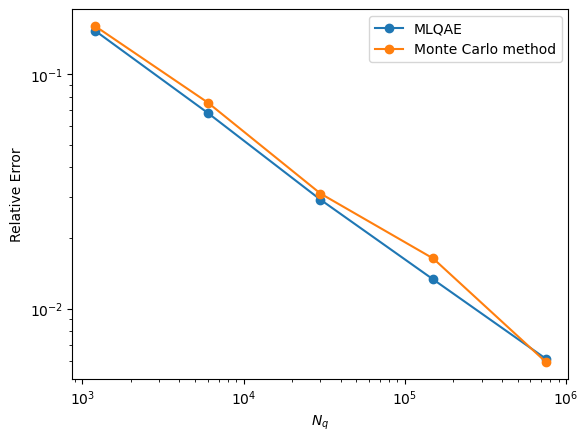

In [108]:
# with 
# shots_list =  [ 200,1000,5000,25000,125000,625000]
# shots_list = np.array(shots_list)*6
# #*8
# repeat = 100
# n_qubits = 8
# y = np.pi/10
plt.plot(shots_list,errors,'-o', label = 'MLQAE')
plt.plot(shots_list,errors_direct, '-o',label = 'Monte Carlo method')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$N_q$')
plt.ylabel('Relative Error')

The below cells are not for execution.

Text(0, 0.5, 'Relative Error')

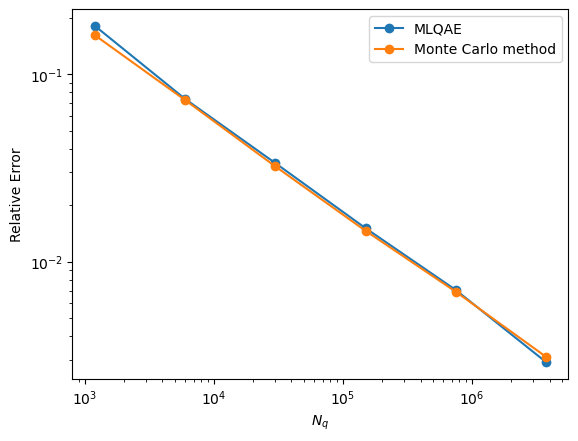

In [42]:
plt.plot(shots_list,errors,'-o', label = 'MLQAE')
plt.plot(shots_list,errors_direct, '-o',label = 'Monte Carlo method')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$N_q$')
plt.ylabel('Relative Error')

Text(0.5, 0, 'depth(# of A)')

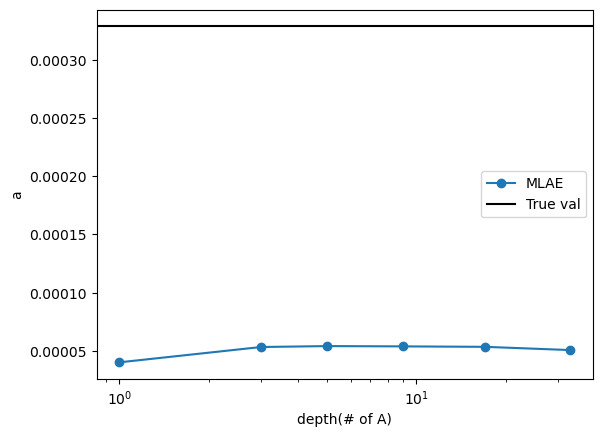

In [22]:
theta_Candidates = cal_theta(n_grovers, hits, shots=shots)
plt.plot(2*np.array(n_grovers)+1, np.sin(theta_Candidates)**2, '-o', label = 'MLAE')
plt.axhline(analytic_result, c='k', label = 'True val')
plt.legend()
plt.xscale('log')
plt.ylabel('a')
plt.xlabel('depth(# of A)')

Text(0.5, 0, 'depth(# of A)')

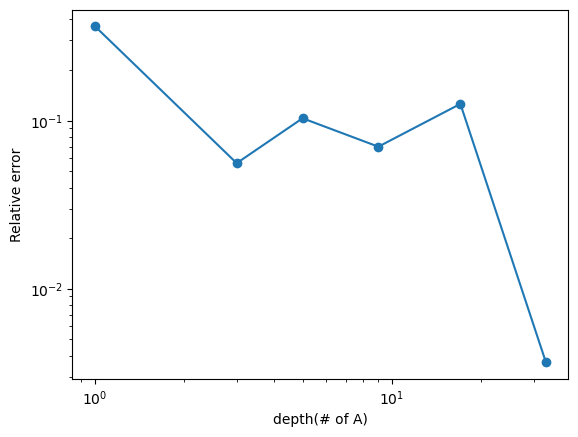

In [238]:
plt.plot(2*np.array(n_grovers)+1, np.abs(np.sin(theta_Candidates)**2-analytic_result)/analytic_result, '-o')

plt.xscale('log')
plt.yscale('log')
plt.ylabel('Relative error')
plt.xlabel('depth(# of A)')

In [235]:
shots_list = [1*6, 5*6, 10*6, 15*6, 20*6, 25*6, 30*6, 50*6, 100*6]#,1000*6]

repeat = 100
n_qubits = 11
y = np.pi/3
N = 2**(n_qubits-1)
target = n_qubits -1

# dev = qml.device('lightning.gpu', wires = n_qubits, shots = shots)

analytic_result = (y / 2. - np.sin(2 * y) / 4.)/y 
print("Analytical Result:", analytic_result)


for shots in shots_list:
    dev = qml.device('default.qubit', wires = n_qubits, shots = shots)
    ret = [] 
    for _ in range(repeat): 
        @qml.qnode(device = dev)
        def circuit():
            # define function 

            def A():
                # superposition 
                for i in range(n_qubits-1):
                    qml.Hadamard(wires = i)
                # encode f(x)
                qml.RY(y/N, wires = target )
                for i in range(n_qubits-1):
                    qml.CRY(2**(i+1) * y/ N , wires = [i, target])

            # start circuit 
            A()
            return qml.sample(wires = target)
        ret.append(np.mean(circuit()))
    print(f'shot: {shots} |'+'표준편차 추정값', np.std(ret_rep),'표준편차 참값', np.sqrt(1/(shots)*analytic_result * ( 1- analytic_result)), ', Relative error', np.std(ret_rep)/analytic_result) #*np.sqrt(100), 
    
    

Analytical Result: 0.2932516642168279
shot: 6 |평균 0.3 표준편차 0.20816659994661327 Relative error 0.7098564998856973
shot: 30 |평균 0.2846666666666666 표준편차 0.08748587187527924 Relative error 0.29833035085725174
shot: 60 |평균 0.29633333333333334 표준편차 0.060625443870081855 Relative error 0.20673520824507885
shot: 90 |평균 0.2867777777777778 표준편차 0.0499801195044491 Relative error 0.170434222898371
shot: 120 |평균 0.29575 표준편차 0.04318074094881755 Relative error 0.14724806784690592
shot: 150 |평균 0.29346666666666665 표준편차 0.039282226685020454 Relative error 0.13395397700445952
shot: 180 |평균 0.2992222222222222 표준편차 0.036012857786156406 Relative error 0.1228052972259649
shot: 300 |평균 0.2934 표준편차 0.027700701956609133 Relative error 0.09446051066952328
shot: 600 |평균 0.2925333333333333 표준편차 0.020280642111245997 Relative error 0.06915780739184707


In [234]:
np.sqrt(1/100*21/600)

0.01870828693386971

In [156]:
shots = 1000
dev = qml.device('default.qubit', wires = n_qubits, shots = shots)

n_grovers = [0,1,2,4,8,16,32]

ret = []
for n_grover in n_grovers:
    @qml.qnode(device = dev)
    def circuit(n_grover):
        n_qubits = 3
        n = n_qubits - 1
        N=2**(n_qubits - 1)
        target = n_qubits-1

        p = np.ones(N)/N
        theta_i = np.arange(N)/2
        a = np.sum(p * np.sin(theta_i/2)**2)
            
        def Rotf(n, theta_i):
            print("rot")
            qubits = np.arange(n)
            
            
            # for i in range(1,4):#range(2**n):
            #     binary=format(i, 'b').zfill(n)
            #     ctr = [int(x) for x in binary]
            #     print(ctr, target)
            #     qml.ctrl(qml.RY, qubits , control_values=ctr)(theta_i[i], wires=target)
                
            # print('target', target)
                
        def A(p,theta_i,n):
            
            # prepare state 
            psi = np.sqrt(p)
            overlap = psi[0]
            denominator = np.sqrt(2 + 2 * overlap)
            psi[0] += 1
            psi /= denominator
            dim = len(p)
            for i in range(n): 
                qml.Hadamard(wires = i)
            # qml.QubitUnitary(2 * np.outer(psi, psi) - np.eye(dim), wires=np.arange(n))
            
            # encode f[x] = sin^2(theta_i[x]/2)
            Rotf(n, theta_i)

        def reflect(n_qubits, target):
            for i in range( n_qubits):
                qml.PauliX(wires =i)
            qml.ctrl(qml.PauliZ, range(n_qubits-1), control_values=[1 for _ in range(n_qubits-1)])(wires = target)
            for i in range( n_qubits):
                qml.PauliX(wires =i)

        def Q(p, theta_i, n, target):
            # reflect respect to |psi_g>|1> 
            qml.PauliZ(wires = target)
            # reflect respect to chi
            qml.adjoint(A)(p,theta_i,n)
            reflect(n+1, target)
            A(p,theta_i,n)
            
        #Start circuit    
        
        A(p, theta_i, n) 
        # print("A")
        print(n_grover)
        for _ in range(n_grover):
            Q(p,theta_i, n, target)
        ret = qml.sample(wires = target)
        # ret = qml.probs(wires = target)
        
        return ret
    
    circuit_output = circuit( n_grover)
    ret.append(circuit_output)
hits = []
for i in ret: 
    hits.append(np.sum(i).item()) # count number of 1s 
print(ret)
print(hits)

rot
0
rot
1
rot
rot


DeviceError: Operation QubitStateVector cannot be used after other Operations have already been applied on a lightning.gpu device.

In [150]:
N=4
theta_i = np.arange(N)/2
sum(np.concatenate((np.sin(theta_i/2), np.cos(theta_i/2) ))**2)


4.0

In [128]:
print(ret)

[tensor([0.833, 0.167], requires_grad=True), tensor([0.806, 0.194], requires_grad=True), tensor([0.803, 0.197], requires_grad=True), tensor([0.817, 0.183], requires_grad=True), tensor([0.806, 0.194], requires_grad=True), tensor([0.802, 0.198], requires_grad=True), tensor([0.819, 0.181], requires_grad=True)]


Text(0.5, 0, 'depth(# of Q)')

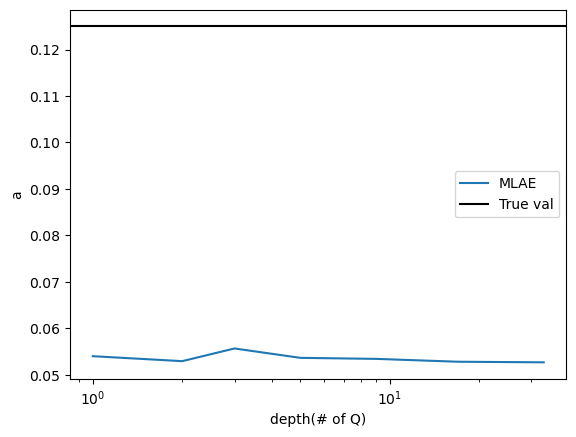

In [75]:
theta_Candidates = cal_theta(n_grovers, hits, shots=shots)
plt.plot(np.array(n_grovers)+1, np.sin(theta_Candidates)**2, label = 'MLAE')
plt.axhline(a, c='k', label = 'True val')
plt.legend()
plt.xscale('log')
plt.ylabel('a')
plt.xlabel('depth(# of Q)')